# What is GAN?

このファイルではGANの簡単なアーキテクチャと実装方法について解説を行う。具体的な理論の解説は行わない。<br>
具体的な理論に関してはIan Goodfellowとその同僚のGAN原論文[Generative Adversarial Networks](https://arxiv.org/pdf/1406.2661.pdf)を参考にしてほしい<br>

GANの簡単なアーキテクチャ図は以下の通りである。(画像は[Generative Adversarial Networks (GANs) Tutorial](https://www.kaggle.com/code/emreustundag/generative-adversarial-networks-gans-tutorial)からとってきている)<br>
<img src = "https://www.researchgate.net/publication/340458845/figure/fig1/AS:879437700669440@1586685695381/The-architecture-of-vanilla-GANs.ppm">

GANのニューラルネットワーク部分はGenerative Networkと、Discriminative Networkである。<br>
Generative Networkは日本語ではよく生成器と言われ、ランダムな入力が与えられた時偽の画像を生成するニューラルネットワークであり、<br>
Discriminative Networkは日本語ではよく識別器と言われ、入力に本物の画像か偽の画像が与えられ、本物の画像か偽物の画像かを識別するニューラルネットワークである。<br>
識別器は偽の画像をよく判別できるように訓練し、生成器は識別器をうまく騙せるような画像を制作するように訓練することが求められる。<br>

これら2つの目的を達成する為に、目的関数$V(\theta^{(D)},\theta^{(G)})$が定義される。<br>
$$
V(\theta^{(D)},\theta^{(G)}) = E_{X\verb|~|P_{data}(X)}[\log{D(X)}] + E_{Z\verb|~|P_{z}(Z)}[\log{(1-D(G(Z)))}]
$$
上の式において$D(•)$は識別器の出力であり、$[0,1]$の値を取る。$G(•)$は生成器の出力であり生成された偽のデータを意味する<br>
第一項が識別器の性能に関する項であり、第二項が生成器の性能に関する項である。<br>
この目的関数を識別器Dにに対しては最大化し、生成器Gに対しては最小化することを目指す、つまり<br>
$$
\underset{G}\min\,\underset{D}\max{V(\theta^{(D)},\theta^{(G)}) = \underset{G}\min\,\underset{D}\max{E_{X\verb|~|P_{data}(X)}[\log{D(X)}] + E_{Z\verb|~|P_{z}(Z)}[\log{(1-D(G(Z)))}]}}
$$

を計算することがGANの学習方法となる。数式だけだと非常に簡潔に思えるが、実際の訓練の際には<br>第一項もしくは第二項のどちらにも過剰に適合しすぎてはいけないことに注意しなければならない

実際の訓練の際は、生成器のパラメータを固定し、識別器のパラメーターを最適化したのちに、識別器のパラメータを固定し、生成器のパラメーターを最適化する。<br>
という手順で学習を行う。

では最初のGANの学習に移ろう、最初はVanilla GANの実装を行う。<br>
このファイルではMNISTのGANモデルを制作することを目指す。

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np
from torchvision import transforms
import torchvision
from tqdm import tqdm
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import warnings
warnings.simplefilter('ignore')
print("CUDA環境が壊れていないことを祈りながら確認-> ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

CUDA環境が壊れていないことを祈りながら確認->  False


Vanilla GANの生成器と識別器は非常に簡単な構造をしている。

In [2]:
z_size = 64
GNet = nn.Sequential(nn.Linear(z_size,100),nn.LeakyReLU(),nn.Linear(100,784),nn.Tanh()).to(device)
DNet = nn.Sequential(nn.Linear(784,100),nn.LeakyReLU(),nn.Linear(100,1),nn.Sigmoid()).to(device)
print("Vanilla GAN 生成器\n", GNet)
print("Vanilla GAN 識別器\n", DNet)

Vanilla GAN 生成器
 Sequential(
  (0): Linear(in_features=64, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=784, bias=True)
  (3): Tanh()
)
Vanilla GAN 識別器
 Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=1, bias=True)
  (3): Sigmoid()
)


次にMNIST Datasetを用意する。transformでピクセルの明るさの範囲を[-1,1]にすることで学習を改善するよう前処理を行っていることに注意してほしい。

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5), std = (0.5))])
mnist_data = torchvision.datasets.MNIST(root = "./",train=True, transform=transform,download=True)

生成器の入力Zを生成するcreate_input関数と訓練を行うtrainGAN関数を制作する。<br>
これらの関数は非常によく使うことが想定される為、モジュール化してGANutilsフォルダを制作しいれておくことにする。

In [4]:
#入力zを制作する関数
def create_input(batch_size, z_size, mode = "uniform"):
    if mode == "uniform":
        input_z = torch.rand(batch_size,z_size) * 2 - 1 #[-1,1]の値がでてくる
    else:
        input_z = torch.randn(batch_size,z_size)
    return input_z
def trainGAN(z_size: int, real_data: torch.Tensor, G: nn.Module, D: nn.Module, optimizerG: optim.Optimizer, optimizerD: optim.Optimizer,device):
    #まず識別器のモデルを改善した後に生成器のモデルを改善する
    criterion = nn.BCELoss()
    optimizerD.zero_grad()
    batch_size = real_data.size(0)
    real_data = real_data.view(batch_size,-1) #入力ように整形
    real_label = torch.ones(batch_size,1).to(device)
    real_proba = D(real_data)
    D_loss_real = criterion(real_proba, real_label)
    input_z = create_input(batch_size,z_size).to(device)
    fake_data = G(input_z)
    fake_proba = D(fake_data)
    fake_label = torch.zeros(batch_size,1).to(device)
    D_loss_fake = criterion(fake_proba,fake_label)
    D_loss = D_loss_fake + D_loss_real
    D_loss.backward()
    optimizerD.step()
    #D_lossのところでGenerate Modelのパラメータの勾配も計算されている為、Generate Modelに関する勾配はここで初期化を行う
    optimizerG.zero_grad()
    input_z = create_input(batch_size,z_size).to(device)
    fake_data = G(input_z)
    fake_proba = D(fake_data)
    real_label = torch.ones(batch_size,1).to(device) #ラベルが1になるように(騙すように)訓練するので、ラベルは1を予測するように作る
    G_loss = criterion(fake_proba,real_label)
    G_loss.backward()
    optimizerG.step()
    return D_loss.detach().item(), G_loss.detach().item()

In [21]:
epochs = 100
D_losses = []
G_losses = []
optimizerG = optim.Adam(GNet.parameters(),lr = 1e-4)
optimizerD = optim.Adam(DNet.parameters(),lr = 1e-4)
batch_size = 64
mnist_dl = torch.utils.data.DataLoader(mnist_data,batch_size=batch_size)

In [22]:
for epoch in tqdm(range(epochs)):
    all_D_loss = 0
    all_G_loss = 0
    for data in mnist_dl:
        data = data[0]
        data = data.to(device)
        D_loss, G_loss = trainGAN(z_size,data,GNet,DNet,optimizerG,optimizerD,device)
        all_D_loss += D_loss
        all_G_loss += G_loss
    D_losses.append(all_D_loss/len(mnist_dl))
    G_losses.append(all_G_loss/len(mnist_dl))
    if epoch % 10 == 0:
        print(f"Discriminator Loss: {D_loss},Generater Loss: {G_loss}")
print(f"Discriminator Loss: {D_loss},Generater Loss: {G_loss}")

  1%|          | 1/100 [00:11<19:36, 11.89s/it]

Discriminator Loss: 0.8526073694229126,Generater Loss: 1.2126933336257935


 11%|█         | 11/100 [02:17<19:16, 12.99s/it]

Discriminator Loss: 0.48615193367004395,Generater Loss: 2.2225353717803955


 21%|██        | 21/100 [04:36<19:09, 14.55s/it]

Discriminator Loss: 1.076493740081787,Generater Loss: 1.7143430709838867


 31%|███       | 31/100 [06:49<14:24, 12.52s/it]

Discriminator Loss: 1.200385332107544,Generater Loss: 2.0759313106536865


 41%|████      | 41/100 [08:59<11:42, 11.91s/it]

Discriminator Loss: 0.553421139717102,Generater Loss: 3.7357773780822754


 51%|█████     | 51/100 [10:52<09:15, 11.33s/it]

Discriminator Loss: 0.9627233743667603,Generater Loss: 2.6104917526245117


 61%|██████    | 61/100 [12:45<07:21, 11.33s/it]

Discriminator Loss: 0.9591682553291321,Generater Loss: 3.073105812072754


 71%|███████   | 71/100 [14:39<05:28, 11.33s/it]

Discriminator Loss: 0.6301062703132629,Generater Loss: 2.3635122776031494


 81%|████████  | 81/100 [16:32<03:35, 11.33s/it]

Discriminator Loss: 0.9179105758666992,Generater Loss: 1.9747287034988403


 91%|█████████ | 91/100 [18:26<01:42, 11.36s/it]

Discriminator Loss: 0.8816095590591431,Generater Loss: 1.627279281616211


100%|██████████| 100/100 [20:09<00:00, 12.09s/it]

Discriminator Loss: 0.6519849300384521,Generater Loss: 2.815255880355835


訓練中の損失の変動をみておこう。どちらも損失関数がある値に収束せず、損失が上下を繰り返しているはずである。<br>
これは、訓練が進むにつれて生成器の精度が上がり、本物と偽物の画像を見分けることが識別器には難しくなる為である。

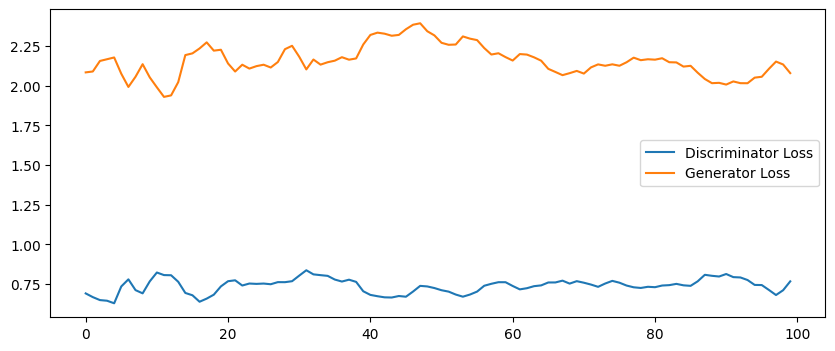

In [23]:
import matplotlib.pyplot as plt
plt.plot(D_losses)
plt.plot(G_losses)
plt.legend(["Discriminator Loss","Generator Loss"])
plt.show()

生成器の損失は上で確認できた、しかしこうした生成モデルは損失は小さく見えていても実際に生成されたものは想定していた出力と異なる場合がある。<br>
訓練したモデルの出力をみておこう。

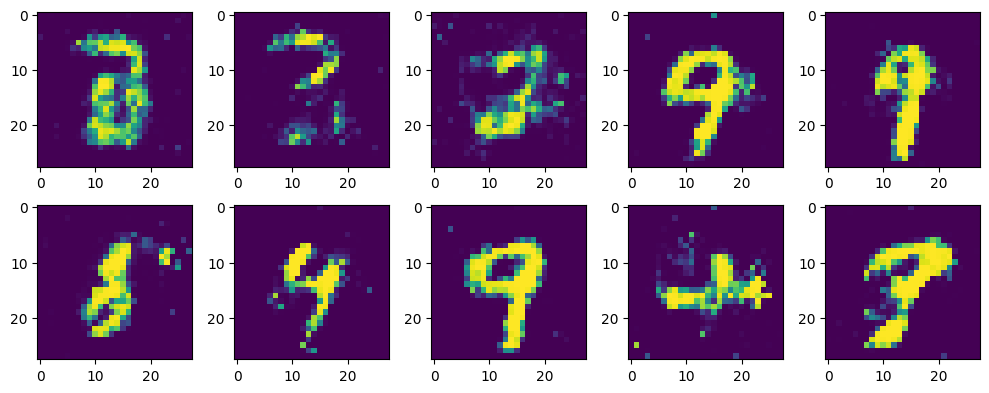

In [25]:
import matplotlib.pyplot as plt
input_z = create_input(10,z_size).to(device)
fake_data = GNet(input_z)
fake_data = fake_data.detach().numpy()
plt.figure(tight_layout=True)
for index, fake_img in enumerate(fake_data):
    ax = plt.subplot(2,5,index+1)
    fake_img = fake_img.reshape(28,28)
    ax.imshow(fake_img)
plt.show()

いくらかの出力はうまくいっているように見えるが、まだ数字を表しているのか不明な画像も多くみられる結果が得られたと思う。<br>
ここまでは、全結合層のみで識別器も生成器も制作をおこなった。しかし、CNNに代表されるように、画像の特徴量を取り出すには畳み込みを用いた演算を用いた方が良い。<br>
そこで、畳み込みによるGANの改善を図ったDCGANを実装していく。